In [1]:
import dynet as dy
import numpy as np

# `dyNet` example: `spam` v. `ham`

## import features

In [2]:
import sys
sys.path.append("..")
import utils as u

In [3]:
# change this string to match the path on your computer
path_to_root = "/Users/mcapizzi/Github/dynet_tutorial/"

In [4]:
trainX, trainY, testX, testY = u.import_data(path_to_root)

loading training data
loading test data


In [5]:
trainX.shape, trainY.shape

((953, 2955), (953,))

In [6]:
testX.shape, testY.shape

((105, 2955), (105,))

In [7]:
testY

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1])

In [8]:
np.nonzero(testX[20])

(array([   0,   21,   27,   47,   77,   93,  118,  147,  229,  231,  239,
         245,  247,  251,  274,  308,  333,  362,  388,  432,  461,  467,
         501,  502,  504,  534,  541,  596,  612,  613,  616,  619,  622,
         627,  636,  657,  741,  763,  816,  845,  849,  870,  885,  921,
         972,  991, 1024, 1060, 1083, 1116, 1128, 1160, 1224, 1258, 1290,
        1322, 1327, 1393, 1408, 1419, 1424, 1437, 1456, 1530, 1531, 1566,
        1625, 1628, 1636, 1643, 1685, 1740, 1751, 1803, 1867, 1936, 1956,
        2004, 2007, 2032, 2053, 2091, 2120, 2121, 2135, 2146, 2163, 2202,
        2205, 2210, 2335, 2374, 2376, 2392, 2427, 2453, 2460, 2466, 2478,
        2487, 2516, 2526, 2544, 2547, 2557, 2575, 2578, 2599, 2627, 2670,
        2678, 2679, 2690, 2701, 2730, 2765, 2790, 2812, 2830, 2856, 2883,
        2887, 2889, 2899]),)

In [9]:
trainX[20][47]

0.01383399209486166

## build architecture
image from here: http://jrmeyer.github.io/tutorial/2016/02/01/TensorFlow-Tutorial.html <br>
text from here: https://www.tensorflow.org/tutorials/wide#how_logistic_regression_works

![logistic_regression](images/logistic_regression.png)

![logistic_regression_math](images/logistic_regression_math.png)

### initialize empty model

See http://dynet.readthedocs.io/en/latest/python_ref.html#parametercollection

In [10]:
lr_model = dy.ParameterCollection()   # used to be called dy.Model()
lr_model

### dimensions

In [11]:
# size of input (2955)
input_size = trainX.shape[1]
# size of output
output_size = 1

### weight matrices and bias vectors

#### paramater `initializer`
See http://dynet.readthedocs.io/en/latest/python_ref.html#parameters-initializers

In [12]:
initializer = dy.GlorotInitializer(gain=4.0)

In [13]:
# W (input x output) as a Parameters object
pW = lr_model.add_parameters(
    (input_size, output_size),
    init=initializer
)
type(pW), type(dy.parameter(pW))

(_dynet.Parameters, _dynet.Expression)

In [14]:
# check the shape of the Expression
dy.parameter(pW).npvalue().shape

(2955, 1)

In [15]:
# b (1 x output) as a Parameters object
pb = lr_model.add_parameters(
    (1, output_size),
    init=initializer
)
# check the shape
dy.parameter(pb).npvalue().shape

(1, 1)

### forward operations

In [16]:
def forward_pass(x):
    """
    This function will wrap all the steps of the forward pass
    :param x: the input
    """
    # convert input to Expression (this step must happen here b/c of autobatching)
    x = dy.inputTensor(x)
    # convert Parameters to Expressions
    W = dy.parameter(pW)
    b = dy.parameter(pb)
    affine_transformation = x * W + b          
    # calculate and return the sigmoid activation
    return dy.logistic(affine_transformation)

### training

#### initializing a `trainer`
See http://dynet.readthedocs.io/en/latest/python_ref.html#optimizers

In [17]:
trainer = dy.SimpleSGDTrainer(
    m=lr_model,
    learning_rate=0.01
)

### autobatching
See http://dynet.readthedocs.io/en/latest/minibatch.html#

In [19]:
dyparams = dy.DynetParams()
dyparams.set_autobatch(True)
dyparams.set_random_seed(1978)
dyparams.init()

#### one `epoch`

In [20]:
# store original values of W (for comparison)
original_W = dy.parameter(pW).npvalue()
# begin a clean computational graph
dy.renew_cg()
# initialize list to capture individual losses
losses = []

In [21]:
# iterate through the dataset
for i in range(trainX.shape[0]):
    # prepare input
    x = np.expand_dims(trainX[i], axis=0)   # must make it a vector with dimensions (1 x voc_size)
    # prepare output
    y = dy.scalarInput(trainY[i])
    # make a forward pass
    pred = forward_pass(x)
    # calculate loss for each example
    loss = dy.binary_log_loss(pred, y) 
    losses.append(loss)

In [22]:
# get total loss for dataset
total_loss = dy.esum(losses)
# apply the calculations of the computational graph
total_loss.forward()
# calculate loss to backpropogate
total_loss.backward()
# update parameters with backpropogated error
trainer.update()

In [23]:
# confirm that parameters updated
dy.renew_cg()
print("change in W parameter values: {}".format(
    np.sum(original_W - dy.parameter(pW).npvalue())
))

change in W parameter values: 0.04980689813601202


### testing

#### make a single prediction

In [24]:
pred = forward_pass(np.expand_dims(testX[0], axis=0))
print(pred.value())

0.9980331063270569


#### get predictions on entire test set

In [25]:
all_preds = []
dy.renew_cg()
for i in range(testX.shape[0]):
    x = np.expand_dims(testX[i], axis=0)
    pred = forward_pass(x)
    all_preds.append(pred.value())
original_preds = all_preds

In [26]:
print(original_preds)

[0.9980331063270569, 0.9980347156524658, 0.9980437159538269, 0.9980668425559998, 0.9980653524398804, 0.9980339407920837, 0.9980640411376953, 0.9980395436286926, 0.9980878233909607, 0.9980855584144592, 0.998067319393158, 0.9980345368385315, 0.998045802116394, 0.998033881187439, 0.9980377554893494, 0.9980354905128479, 0.9980818033218384, 0.9980711340904236, 0.9980419874191284, 0.9980369806289673, 0.9980584383010864, 0.9980646967887878, 0.9980259537696838, 0.998080849647522, 0.9980483651161194, 0.998010516166687, 0.9980323314666748, 0.9980414509773254, 0.9980112910270691, 0.9980468153953552, 0.9980159997940063, 0.9980151057243347, 0.9980452656745911, 0.9980307817459106, 0.9980577826499939, 0.9980425834655762, 0.9980545043945312, 0.9980366826057434, 0.9980469942092896, 0.9980255365371704, 0.9980619549751282, 0.9980195164680481, 0.9980536103248596, 0.9980692267417908, 0.9980058670043945, 0.9980220198631287, 0.9980442523956299, 0.9980461001396179, 0.9980714917182922, 0.9980413913726807, 0.99

In [27]:
def check_score(pred, true_y):
    # convert pred to hard label
    label = 1 if pred >= 0.5 else 0
    # compare to true_y
    return 1 if label == true_y else 0

In [28]:
def get_accuracy(list_of_scores):
    return float(sum(list_of_scores) / len(list_of_scores))

In [29]:
accuracy = get_accuracy([check_score(p, y) for p,y in zip(all_preds, list(testY))])
accuracy

0.5333333333333333

### multiple epochs and minibatches

In [30]:
num_epochs = 800
batch_size = 128
num_batches = int(np.ceil(trainX.shape[0] / batch_size))
num_batches

8

In [31]:
# bookeeping
original_W = dy.parameter(pW).npvalue()
epoch_losses = []
all_accuracies = []

In [32]:
# iterate through epochs
for i in range(num_epochs):
    epoch_loss = []
    # reporting
    if i % 100 == 0:
        print("epoch {}".format(i+1))
    # shuffle dataset
    np.random.seed(i)
    np.random.shuffle(trainX)
    np.random.seed(i)           # make sure to reset seed again to keep labels and data together!
    np.random.shuffle(trainY)
    # iterate through batches
    for j in range(num_batches):
        # begin a clean computational graph *at beginning of each batch*
        dy.renew_cg()
        losses = []
        # build the batch
        batchX = trainX[j*batch_size:(j+1)*batch_size]
        batchY = trainY[j*batch_size:(j+1)*batch_size]
        # iterate through the batch
        for k in range(batchX.shape[0]):
            # prepare input
            x = np.expand_dims(batchX[k], axis=0)
            # prepare output
            y = dy.scalarInput(batchY[k])
            # make a forward pass
            pred = forward_pass(x)
            # calculate loss for each example
            loss = dy.binary_log_loss(pred, y)  
            losses.append(loss)
        # get total loss for batch
        total_loss = dy.esum(losses)
        # apply the calculations of the computational graph
        total_loss.forward()
        # calculate loss to backpropogate
        total_loss.backward()
        # update parameters with backpropogated error
        trainer.update()
        # record batch loss
        epoch_loss.append(total_loss.npvalue())
    # record epoch loss
    epoch_losses.append(np.sum(epoch_loss))
    # check performance on test set
    all_preds = []
    dy.renew_cg()
    for i in range(testX.shape[0]):
        x = np.expand_dims(testX[i], axis=0)
        pred = forward_pass(x)
        all_preds.append(pred.value())
    accuracy = get_accuracy([check_score(p, y) for p,y in zip(all_preds, list(testY))])
    all_accuracies.append(accuracy)
# confirm that parameters updated
dy.renew_cg()
print("change in W parameter values: {}".format(
    np.sum(original_W - dy.parameter(pW).npvalue())
))

epoch 1
epoch 101
epoch 201
epoch 301
epoch 401
epoch 501
epoch 601
epoch 701
change in W parameter values: 5.578693352377741


### visualize loss and accuracy

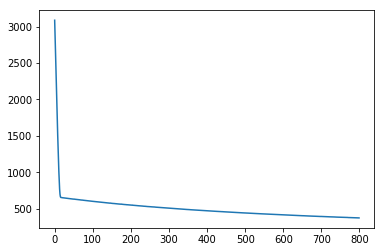

In [33]:
import matplotlib.pyplot as plt
plt.plot(epoch_losses)
plt.show()

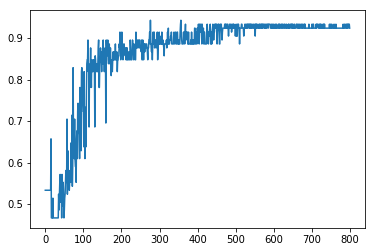

In [34]:
plt.plot(all_accuracies)
plt.show()

### testing

In [35]:
all_preds = []
dy.renew_cg()
for i in range(testX.shape[0]):
    x = np.expand_dims(testX[i], axis=0)
    pred = forward_pass(x)
    all_preds.append(pred.value())

In [36]:
accuracy = get_accuracy([check_score(p, y) for p,y in zip(all_preds, list(testY))])
accuracy

0.9238095238095239